YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  170 of 170 completed


Successfully downloaded data for 170 tickers (out of 170)
Out-of-Sample Performance using Walk-Forward Analysis:
Quantum HRP: Mean Sharpe = 1.4679, Std = 3.7343, Mean PSR = 0.6162
Classical HRP: Mean Sharpe = 1.1999, Std = 3.8850, Mean PSR = 0.5951
Kernel-based HRP: Mean Sharpe = 1.3372, Std = 3.6762, Mean PSR = 0.6089
Markowitz: Mean Sharpe = 1.3546, Std = 3.7798, Mean PSR = 0.6099
Equal Weights: Mean Sharpe = 1.3578, Std = 3.9067, Mean PSR = 0.6044

Average Minimum Track Record Length (MinTRL):
Quantum HRP: inf observations
Classical HRP: inf observations
Kernel-based HRP: inf observations

Using Yahoo Finance Data:
Raw price_data shape: (6202, 170)
Ticker          AAPL  ABBV  ACWI  ADA-USD       ADBE        AGG        AMD  \
Date                                                                         
2005-01-03  0.952312   NaN   NaN      NaN  30.838949  54.190483  21.410000   
2005-01-04  0.962092   NaN   NaN      NaN  30.024111  54.137554  20.209999   
2005-01-05  0.970518   NaN  

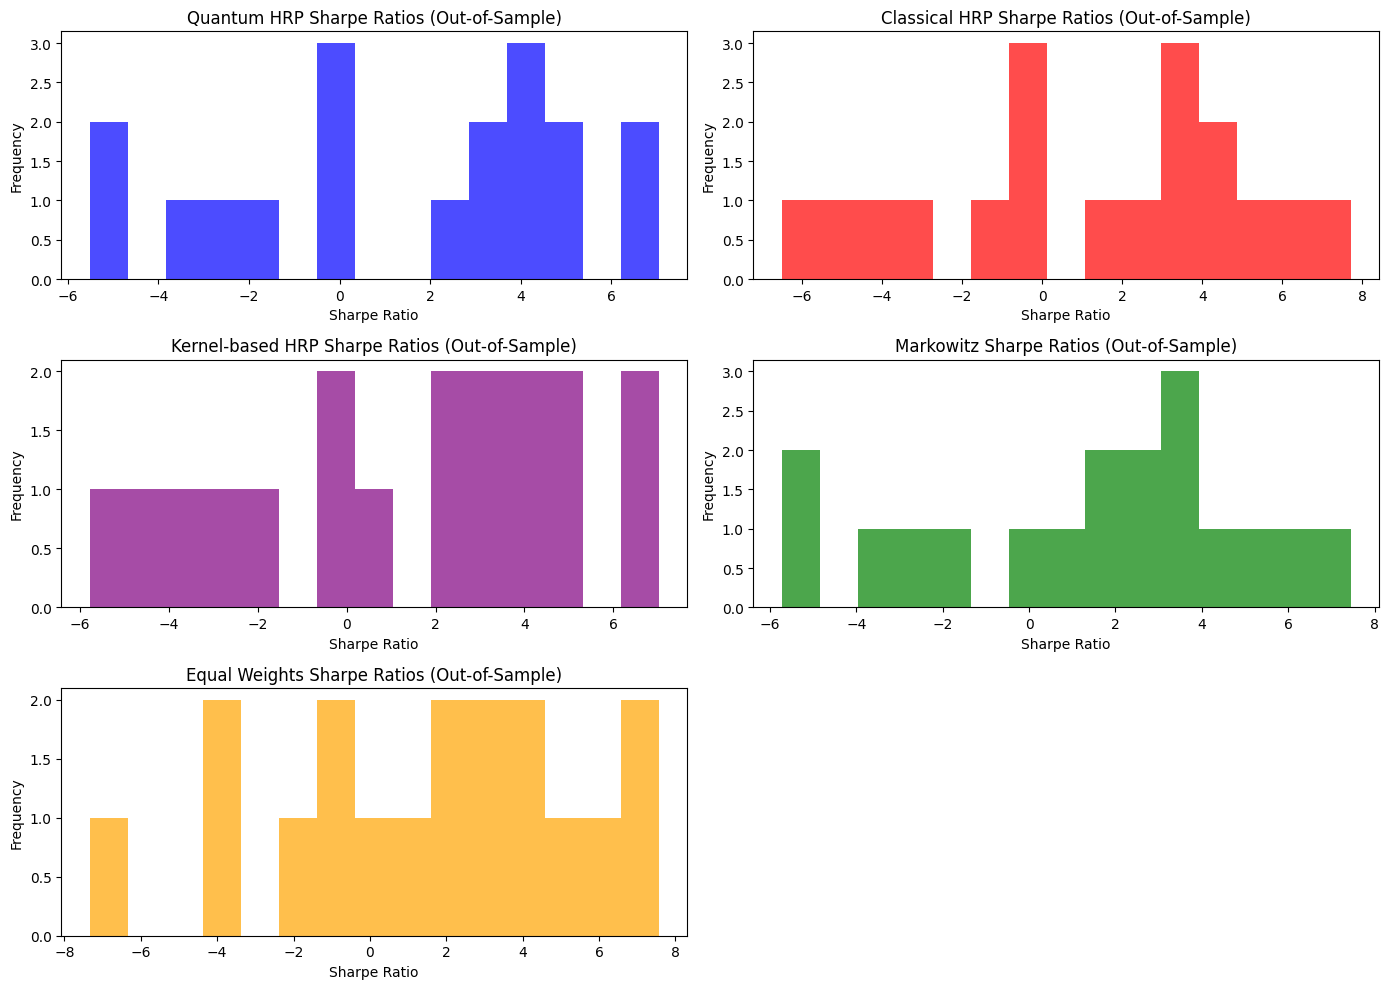

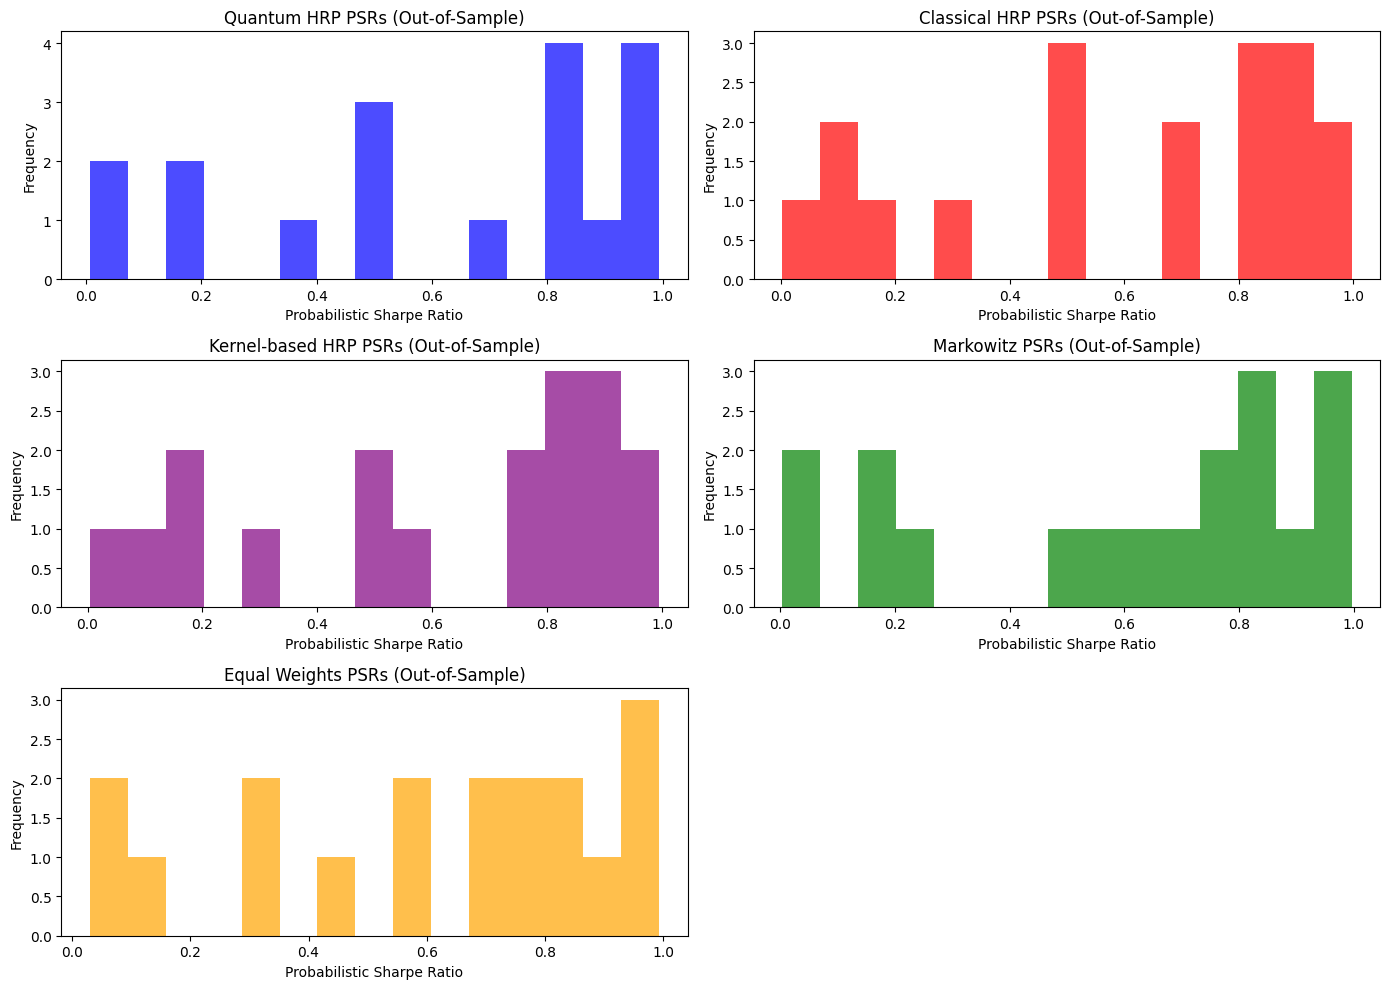

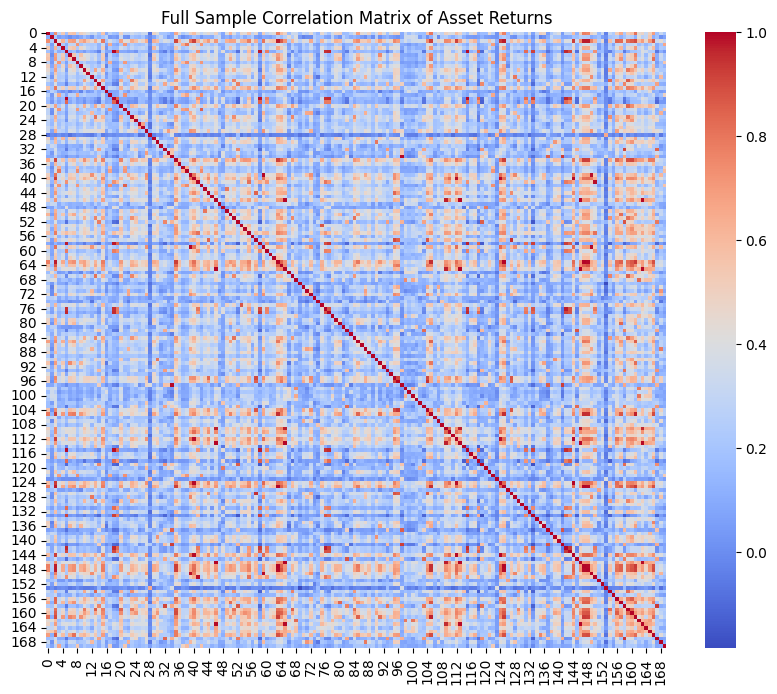

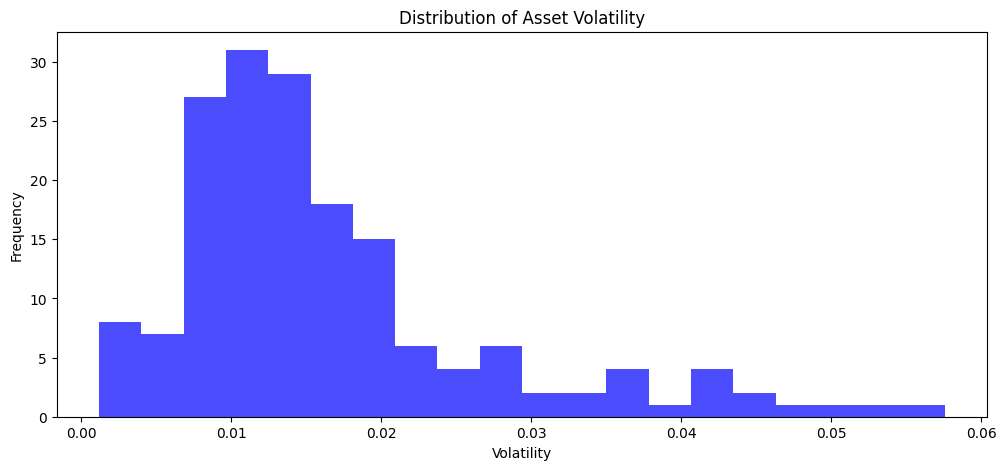


Overall Out-of-Sample Sharpe Ratios based on aggregated test returns:
Quantum HRP: 1.4104
Classical HRP: 1.1246
Kernel-based HRP: 1.2622
Markowitz: 1.2607
Equal Weights: 1.1988


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew, kurtosis
import scipy.stats as stats
from scipy.linalg import eigh
import yfinance as yf
import datetime
import RiskLabAI.utils

# Import HRP functions from RiskLabAI.optimization
from RiskLabAI.optimization import hrp, recursive_bisection

# Import functions from your quantum_hrp.py module
import quantum_hrp
from quantum_hrp import *

# Additional imports needed for clustering and ordering
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform

##############################################
# Main Simulation with Walk-Forward (Out-of-Sample) Analysis
##############################################
def main():
    # Use 'stock' mode with Yahoo Finance data and perform walk-forward (rolling) analysis
    tickers = [
        "SPY", "QQQ", "DIA", "IWM", "IVV", "VTI", "VOO",
        "EFA", "EEM", "VEA", "VWO", "ACWI", "SPDW", "SCHF",
        "XLK", "XLF", "XLE", "XLI", "XLY", "XLV", "XLC", "XLP", "XLRE", "XLU", "XLB",
        "VNQ", "IYR", "RWX", "SCHH", "FREL", "RWO",
        "BNDX", "VWOB", "IGOV", "IEMG", "EMB",
        "GLD", "SLV", "PPLT", "COPX", "DBB", "DBC", "PDBC", "USO", "UGA", "CORN", "WEAT", "SOYB",
        "TLT", "IEF", "LQD", "HYG", "SHY", "TIP", "AGG", "BND", "MBB", "SCHZ", "VCSH", "VCIT",
        "BTC-USD", "ETH-USD", "SOL-USD", "BNB-USD", "XRP-USD", "ADA-USD", "DOGE-USD", "DOT-USD", "AVAX-USD",
        "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "TSLA", "BRK-B", "META", "NFLX", "DIS",
        "JPM", "GS", "BAC", "C", "WFC", "MS", "AXP", "BLK", "SCHW", "TFC",
        "BA", "CAT", "HON", "LMT", "UNP", "CSX", "NSC", "UPS", "FDX", "RTX",
        "CVX", "XOM", "OXY", "MPC", "PSX", "VLO", "SLB", "HAL", "BKR",
        "PG", "KO", "PEP", "MO", "PM", "WMT", "TGT", "HD", "LOW", "MCD", "SBUX", "NKE", "TJX",
        "JNJ", "PFE", "UNH", "CVS", "ABBV", "LLY", "MRNA", "REGN", "BMY", "GILD",
        "AMD", "INTC", "TSM", "ORCL", "IBM", "ADBE", "CRM", "SNOW", "PANW", "AVGO",
        "VZ", "T", "CMCSA", "CHTR", "TMUS", "WBD",
        "BABA", "TCEHY", "TSM", "NIO", "INFY", "SHOP", "SE", "MELI", "BYDDF",
        "GM", "F", "RIVN", "LCID", "NKLA", "XPEV", "LI",
        "ICLN", "TAN", "PBW", "QCLN", "LIT", "FAN", "PBD", "KRBN"
    ]
    start_date = "2005-01-01"
    end_date = "2025-01-01"
    P = 6  # Number of features
    target_SR = 0     # Benchmark Sharpe ratio for PSR calculation
    confidence = 0.95 # Confidence level for MinTRL
    alpha = 2.0       # Quantum feature map parameter
    
    # Fetch stock data from Yahoo Finance
    features, asset_returns, regimes, price_data = fetch_stock_data(tickers, start_date, end_date, P)
    T, N = asset_returns.shape  # T: time, N: assets
    
    # Define training and testing window sizes (in trading days)
    training_window = 756  # approx 3 years of daily data
    test_window = 21       # approx 1 month of daily data
    num_windows = (T - training_window) // test_window
    
    # Initialize lists to store performance metrics for each rolling window
    sr_qhrp_list, psr_qhrp_list, trl_qhrp_list = [], [], []
    sr_classical_list, psr_classical_list, trl_classical_list = [], [], []
    sr_kernel_list, psr_kernel_list, trl_kernel_list = [], [], []
    sr_markowitz_list, psr_markowitz_list = [], []
    sr_equal_list, psr_equal_list = [], []
    
    # To accumulate all out-of-sample returns for an overall metric later
    all_port_ret_qhrp = []
    all_port_ret_classical = []
    all_port_ret_kernel = []
    all_port_ret_markowitz = []
    all_port_ret_equal = []
    
    for w in range(num_windows):
        train_start = w * test_window
        train_end = train_start + training_window
        test_start = train_end
        test_end = test_start + test_window
        if test_end > T:
            break
        
        # Extract training and testing data
        training_returns = asset_returns[train_start:train_end, :]  # shape (training_window, N)
        testing_returns  = asset_returns[test_start:test_end, :]     # shape (test_window, N)
        
        # For each asset, extract training features (shape: (training_window, P))
        training_features = [features[i, train_start:train_end, :] for i in range(N)]
        
        # Compute quantum ordering based on the training features
        avg_rho_list = []
        for i in range(N):
            avg_rho = average_density_matrix(training_features[i], alpha)
            avg_rho_list.append(avg_rho)
        D_quantum = compute_distance_matrix(avg_rho_list)
        q_order = quantum_ordering(D_quantum)
        
        # Classical HRP ordering based on training returns
        classical_order = classical_hrp_ordering(training_returns)
        
        # Kernel-based HRP ordering based on training features using Gaussian MMD distance
        kernel_order = kernel_based_hrp_ordering(training_features, sigma=1.0)
        
        # Compute covariance matrix from training returns
        cov = np.cov(training_returns, rowvar=False)
        
        # Compute portfolio weights for each method
        q_order_list = list(q_order)
        classical_order_list = list(classical_order)
        kernel_order_list = list(kernel_order)
        qhrp_weights = hrp_recursive_bisection(cov, q_order_list)
        classical_hrp_weights = hrp_recursive_bisection(cov, classical_order_list)
        kernel_hrp_weights = hrp_recursive_bisection(cov, kernel_order_list)
        markowitz_w = markowitz_weights(cov)
        equal_w = equal_weights(N)
        
        # Normalize weights (ensure they sum to 1)
        w_qhrp = qhrp_weights.sort_index().values
        w_classical = pd.Series(classical_hrp_weights).sort_index().values
        w_kernel = kernel_hrp_weights.sort_index().values
        w_qhrp = w_qhrp / np.sum(w_qhrp)
        w_classical = w_classical / np.sum(w_classical)
        w_kernel = w_kernel / np.sum(w_kernel)
        markowitz_w = markowitz_w / np.sum(markowitz_w)
        equal_w = equal_w / np.sum(equal_w)
        
        # Compute out-of-sample portfolio returns for the testing period
        port_ret_qhrp = testing_returns.dot(w_qhrp)
        port_ret_classical = testing_returns.dot(w_classical)
        port_ret_kernel = testing_returns.dot(w_kernel)
        port_ret_markowitz = testing_returns.dot(markowitz_w)
        port_ret_equal = testing_returns.dot(equal_w)
        
        # Compute performance metrics for each method using test period returns
        sr_qhrp, psr_qhrp, _, _ = probabilistic_sharpe_ratio(port_ret_qhrp, target_SR, rf=0.01, annualization_factor=252)
        sr_classical, psr_classical, _, _ = probabilistic_sharpe_ratio(port_ret_classical, target_SR, rf=0.01, annualization_factor=252)
        sr_kernel, psr_kernel, _, _ = probabilistic_sharpe_ratio(port_ret_kernel, target_SR, rf=0.01, annualization_factor=252)
        sr_markowitz, psr_markowitz, _, _ = probabilistic_sharpe_ratio(port_ret_markowitz, target_SR, rf=0.01, annualization_factor=252)
        sr_equal, psr_equal, _, _ = probabilistic_sharpe_ratio(port_ret_equal, target_SR, rf=0.01, annualization_factor=252)
        trl_qhrp = min_track_record_length(port_ret_qhrp, target_SR, confidence)
        trl_classical = min_track_record_length(port_ret_classical, target_SR, confidence)
        trl_kernel = min_track_record_length(port_ret_kernel, target_SR, confidence)
        
        sr_qhrp_list.append(sr_qhrp)
        psr_qhrp_list.append(psr_qhrp)
        trl_qhrp_list.append(trl_qhrp)
        sr_classical_list.append(sr_classical)
        psr_classical_list.append(psr_classical)
        trl_classical_list.append(trl_classical)
        sr_kernel_list.append(sr_kernel)
        psr_kernel_list.append(psr_kernel)
        trl_kernel_list.append(trl_kernel)
        sr_markowitz_list.append(sr_markowitz)
        psr_markowitz_list.append(psr_markowitz)
        sr_equal_list.append(sr_equal)
        psr_equal_list.append(psr_equal)
        
        # Accumulate test portfolio returns
        all_port_ret_qhrp.extend(port_ret_qhrp)
        all_port_ret_classical.extend(port_ret_classical)
        all_port_ret_kernel.extend(port_ret_kernel)
        all_port_ret_markowitz.extend(port_ret_markowitz)
        all_port_ret_equal.extend(port_ret_equal)
    
    # Convert lists to arrays for analysis
    sr_qhrp_arr = np.array(sr_qhrp_list)
    psr_qhrp_arr = np.array(psr_qhrp_list)
    sr_classical_arr = np.array(sr_classical_list)
    psr_classical_arr = np.array(psr_classical_list)
    sr_kernel_arr = np.array(sr_kernel_list)
    psr_kernel_arr = np.array(psr_kernel_list)
    sr_markowitz_arr = np.array(sr_markowitz_list)
    psr_markowitz_arr = np.array(psr_markowitz_list)
    sr_equal_arr = np.array(sr_equal_list)
    psr_equal_arr = np.array(psr_equal_list)
    trl_qhrp_arr = np.array(trl_qhrp_list)
    trl_classical_arr = np.array(trl_classical_list)
    trl_kernel_arr = np.array(trl_kernel_list)
    
    # Print aggregated out-of-sample performance metrics
    print("Out-of-Sample Performance using Walk-Forward Analysis:")
    print("Quantum HRP: Mean Sharpe = {:.4f}, Std = {:.4f}, Mean PSR = {:.4f}".format(
        np.mean(sr_qhrp_arr), np.std(sr_qhrp_arr), np.mean(psr_qhrp_arr)))
    print("Classical HRP: Mean Sharpe = {:.4f}, Std = {:.4f}, Mean PSR = {:.4f}".format(
        np.mean(sr_classical_arr), np.std(sr_classical_arr), np.mean(psr_classical_arr)))
    print("Kernel-based HRP: Mean Sharpe = {:.4f}, Std = {:.4f}, Mean PSR = {:.4f}".format(
        np.mean(sr_kernel_arr), np.std(sr_kernel_arr), np.mean(psr_kernel_arr)))
    print("Markowitz: Mean Sharpe = {:.4f}, Std = {:.4f}, Mean PSR = {:.4f}".format(
        np.mean(sr_markowitz_arr), np.std(sr_markowitz_arr), np.mean(psr_markowitz_arr)))
    print("Equal Weights: Mean Sharpe = {:.4f}, Std = {:.4f}, Mean PSR = {:.4f}".format(
        np.mean(sr_equal_arr), np.std(sr_equal_arr), np.mean(psr_equal_arr)))
    print("\nAverage Minimum Track Record Length (MinTRL):")
    print("Quantum HRP: {:.4f} observations".format(np.mean(trl_qhrp_arr)))
    print("Classical HRP: {:.4f} observations".format(np.mean(trl_classical_arr)))
    print("Kernel-based HRP: {:.4f} observations".format(np.mean(trl_kernel_arr)))
    
    # Also print raw data details as in the original code
    print("\nUsing Yahoo Finance Data:")
    print("Raw price_data shape:", price_data.shape)
    print(price_data.head())
    print("Tickers (columns):", price_data.columns)
    
    # Compute full-sample covariance and correlation matrices for reference
    full_cov = np.cov(asset_returns, rowvar=False)
    print("\nFull Sample Covariance Matrix:")
    print(full_cov)
    full_corr = np.corrcoef(asset_returns, rowvar=False)
    print("\nFull Sample Correlation Matrix:")
    print(full_corr)
    rolling_volatility = asset_returns.std(axis=0)
    print("\nRolling Volatility (std of returns) for each asset:")
    print(rolling_volatility)
    
    # Plot histograms for Sharpe ratios
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 2, 1)
    plt.hist(sr_qhrp_arr, bins=15, color='blue', alpha=0.7)
    plt.title('Quantum HRP Sharpe Ratios (Out-of-Sample)')
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Frequency')
    plt.subplot(3, 2, 2)
    plt.hist(sr_classical_arr, bins=15, color='red', alpha=0.7)
    plt.title('Classical HRP Sharpe Ratios (Out-of-Sample)')
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Frequency')
    plt.subplot(3, 2, 3)
    plt.hist(sr_kernel_arr, bins=15, color='purple', alpha=0.7)
    plt.title('Kernel-based HRP Sharpe Ratios (Out-of-Sample)')
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Frequency')
    plt.subplot(3, 2, 4)
    plt.hist(sr_markowitz_arr, bins=15, color='green', alpha=0.7)
    plt.title('Markowitz Sharpe Ratios (Out-of-Sample)')
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Frequency')
    plt.subplot(3, 2, 5)
    plt.hist(sr_equal_arr, bins=15, color='orange', alpha=0.7)
    plt.title('Equal Weights Sharpe Ratios (Out-of-Sample)')
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    # Plot histograms for PSRs
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 2, 1)
    plt.hist(psr_qhrp_arr, bins=15, color='blue', alpha=0.7)
    plt.title('Quantum HRP PSRs (Out-of-Sample)')
    plt.xlabel('Probabilistic Sharpe Ratio')
    plt.ylabel('Frequency')
    plt.subplot(3, 2, 2)
    plt.hist(psr_classical_arr, bins=15, color='red', alpha=0.7)
    plt.title('Classical HRP PSRs (Out-of-Sample)')
    plt.xlabel('Probabilistic Sharpe Ratio')
    plt.ylabel('Frequency')
    plt.subplot(3, 2, 3)
    plt.hist(psr_kernel_arr, bins=15, color='purple', alpha=0.7)
    plt.title('Kernel-based HRP PSRs (Out-of-Sample)')
    plt.xlabel('Probabilistic Sharpe Ratio')
    plt.ylabel('Frequency')
    plt.subplot(3, 2, 4)
    plt.hist(psr_markowitz_arr, bins=15, color='green', alpha=0.7)
    plt.title('Markowitz PSRs (Out-of-Sample)')
    plt.xlabel('Probabilistic Sharpe Ratio')
    plt.ylabel('Frequency')
    plt.subplot(3, 2, 5)
    plt.hist(psr_equal_arr, bins=15, color='orange', alpha=0.7)
    plt.title('Equal Weights PSRs (Out-of-Sample)')
    plt.xlabel('Probabilistic Sharpe Ratio')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    # Plot full-sample correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(full_corr, cmap="coolwarm", annot=False)
    plt.title("Full Sample Correlation Matrix of Asset Returns")
    plt.show()
    
    # Plot histogram of rolling volatility
    plt.figure(figsize=(12, 5))
    plt.hist(rolling_volatility, bins=20, color="blue", alpha=0.7)
    plt.title("Distribution of Asset Volatility")
    plt.xlabel("Volatility")
    plt.ylabel("Frequency")
    plt.show()
    
    # Additionally, compute overall out-of-sample portfolio returns and metrics across all windows
    all_port_ret_qhrp = np.array(all_port_ret_qhrp)
    all_port_ret_classical = np.array(all_port_ret_classical)
    all_port_ret_kernel = np.array(all_port_ret_kernel)
    all_port_ret_markowitz = np.array(all_port_ret_markowitz)
    all_port_ret_equal = np.array(all_port_ret_equal)
    overall_sr_qhrp = sharpe_ratio(all_port_ret_qhrp, rf=0.01, annualization_factor=252)
    overall_sr_classical = sharpe_ratio(all_port_ret_classical, rf=0.01, annualization_factor=252)
    overall_sr_kernel = sharpe_ratio(all_port_ret_kernel, rf=0.01, annualization_factor=252)
    overall_sr_markowitz = sharpe_ratio(all_port_ret_markowitz, rf=0.01, annualization_factor=252)
    overall_sr_equal = sharpe_ratio(all_port_ret_equal, rf=0.01, annualization_factor=252)
    print("\nOverall Out-of-Sample Sharpe Ratios based on aggregated test returns:")
    print("Quantum HRP: {:.4f}".format(overall_sr_qhrp))
    print("Classical HRP: {:.4f}".format(overall_sr_classical))
    print("Kernel-based HRP: {:.4f}".format(overall_sr_kernel))
    print("Markowitz: {:.4f}".format(overall_sr_markowitz))     
    print("Equal Weights: {:.4f}".format(overall_sr_equal))
    
if __name__ == '__main__':
    main()
